<a href="https://colab.research.google.com/github/Shona173/codes/blob/main/3DSDF_OT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install POT
!pip install trimesh
!pip install pyrender
!pip install ffmpeg-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.3/709.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.1/962.1 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.7 MB/s eta 0:00:00
  Created wheel for PyOpenGL: filename=PyOpenGL-3.1.0-py3-none-any.whl size=1745193 sha256=fba202e7cc8e8e13c266a57e29302de91ac35d6af113c48581621cfafb7b73c9
  Stored in directory: /root/.cache/pip/wheels/2f/37/f5/f88cd3dddf75bc3ce608e44bf8a79078c408bf1f351a50818e
Successfully built PyOpenGL
  Attempting uninstall: PyOpenGL
    Found existing installation: PyOpenGL 3.1.9
    Uninstalling PyOpenGL-3.1.9:
      Successfully uninstalled PyOpenGL-3.1.9


In [6]:
import numpy as np
import numpy.random as random

import matplotlib.pyplot as plt
import skimage.measure
import trimesh
import pyrender
import matplotlib.animation as animation
from google.colab import files
from matplotlib import animation
from IPython.display import HTML
import ot
import time

In [7]:
def clamp(value, min_val, max_val):
    return np.maximum(min_val, np.minimum(value, max_val))

In [8]:
def ndot(a,b):
    return a[0]*b[0]-a[1]*b[1]

In [9]:
def sdf_sphere(p, s=0.5):
    p = p.copy()
    return np.sqrt(np.sum(p**2, axis=1))-s

In [10]:
def sdf_box(p, b=[0.5,0.5,0.5]):
    p = p.copy()
    q = np.abs(p) - b
    return np.linalg.norm(np.maximum(q, 0.0)) + np.minimum(np.maximum(q[:,0], np.maximum(q[:,1], q[:,2])), 0.0)

In [11]:
def sdf_octahedron(p, s=0.5):
    p = np.abs(p)
    m = np.sum(p, axis=1) - s
    d = np.zeros(p.shape[0])

    # Get index for each branch
    idx_x = 3.0 * p[:, 0] < m
    idx_y = (~idx_x) & (3.0 * p[:, 1] < m)
    idx_z = (~idx_x) & (~idx_y) & (3.0 * p[:, 2] < m)
    idx_else = ~(idx_x | idx_y | idx_z)

    # Build q for each condition
    q = np.zeros_like(p)
    q[idx_x] = p[idx_x]
    q[idx_y] = p[idx_y][:, [1, 2, 0]]
    q[idx_z] = p[idx_z][:, [2, 0, 1]]

    # Calculate distance for q
    k = clamp(0.5 * (q[:, 2] - q[:, 1] + s), 0.0, s)
    d_tmp = np.linalg.norm(np.stack([q[:, 0], q[:, 1] - s + k, q[:, 2] - k], axis=1), axis=1)

    # Assign to d according to condition
    d[idx_x | idx_y | idx_z] = d_tmp[idx_x | idx_y | idx_z]
    d[idx_else] = m[idx_else] * 0.57735027  # 1/sqrt(3)

    return d

In [12]:
def r_union(f1, f2):
    return f1 + f2 + np.sqrt(f1**2 + f2**2)

In [13]:
def r_intersection(f1, f2):
    return f1 + f2 - np.sqrt(f1**2 + f2**2)

In [14]:
def space_time_blending(f1, f2, t, x, a0=1.0, a1=1.0, a2=1.0):
    f1x = f1(x)
    f2x = f2(x)

    f1x_cyl = r_intersection(f1x, -t)
    f2x_cyl = r_intersection(f2x, (t-1))

    disp = a0 / (1.0 + (f1x_cyl/a1)**2 + (f2x_cyl/a2)**2)
    r_uni = r_union(f1x_cyl, f2x_cyl)

    return r_uni + disp

In [15]:
def visualize_space_time_blending_3d(f1, f2, t, grid_size=64, bounds=(-2, 2)):

    x = np.linspace(bounds[0], bounds[1], grid_size)
    y = np.linspace(bounds[0], bounds[1], grid_size)
    z = np.linspace(bounds[0], bounds[1], grid_size)
    X, Y, Z = np.meshgrid(x, y, z, indexing="ij")

    grid = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    sdf_values = space_time_blending(f1, f2, np.array([t]), grid).reshape(grid_size, grid_size, grid_size)

    verts,faces,normals,_=skimage.measure.marching_cubes(sdf_values, level=0.0)

    mesh=trimesh.Trimesh(vertices=verts, faces=faces, vertex_normals=normals)

    scene=pyrender.Scene()
    scene.add(pyrender.Mesh.from_trimesh(mesh))
    viewer=pyrender.Viewer(scene, use_raymond_lighting=True, run_in_thread=True)

    return mesh

In [16]:
def gen_grid(resolution, low=-1.0, high=1.0):
    idx = np.linspace(low, high, num=resolution)
    x, y, z = np.meshgrid(idx, idx,idx)
    V = np.concatenate((x.reshape((-1,1)), y.reshape((-1,1)),z.reshape((-1,1))), 1)

    return V

In [17]:
def sample_and_normalize(f, grid, grid_size):
    '''
    Sample f on the grid and normalize it.
    Assume f>0 outside and <0 inside.
    '''
    print(grid.shape)
    fv = f(grid)
    print(fv.shape)

    # >0 inside
    fv = -fv

    # f is the characteristic function for {f>0}
    fv[fv>=0.0] = 1.0
    fv[fv<0.0] = 0.0

    total_sum = np.sum(fv)
    if total_sum > 0:
        fv = fv / total_sum
    else:
        raise ValueError("The sum of the function values is zero; normalization is not possible.")

    # reshape to have the same shape as grid
    fv = fv.reshape(grid_size, grid_size,grid_size)

    return fv

In [18]:
def convolutional_barycenter3d(mu_list, alpha_list, Ht_func, a, max_iter=100, sharpen_entropy=None):
    k = len(mu_list)
    n = mu_list[0].size
    v = [np.ones_like(mu_list[0]) for _ in range(k)]
    w = [np.ones_like(mu_list[0]) for _ in range(k)]
    for _ in range(max_iter):
        d = []
        for i in range(k):
            w[i] = mu_list[i].flatten() / (Ht_func(a * v[i]) + 1e-8)
            d_i = v[i] * Ht_func(a * w[i])
            d.append(d_i)
        mu = np.ones_like(mu_list[0])
        for i in range(k):
            mu *= np.power(d[i], alpha_list[i])
        if sharpen_entropy is not None:
            H = -np.sum(a * mu * np.log(np.maximum(mu, 1e-8)))
            if H > sharpen_entropy:
                beta = sharpen_entropy / H
                mu = np.power(mu, beta)
                mu /= np.sum(mu * a)
        for i in range(k):
            v[i] = v[i] * mu / (d[i] + 1e-8)
    return mu.reshape(mu_list[0].shape)

NameError: name 'grid' is not defined

Error in callback <function _draw_all_if_interactive at 0x7c748a2ae8e0> (for post_execute):


NameError: name 'grid' is not defined

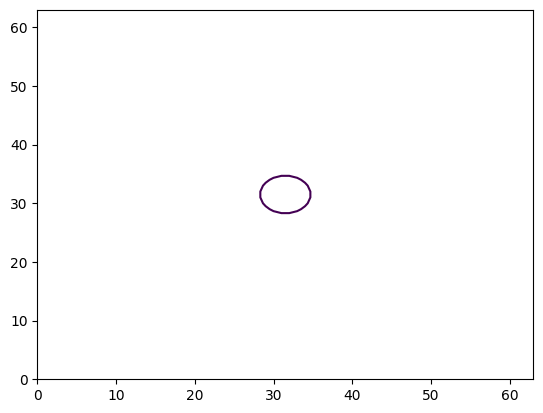

In [19]:
start=time.time()
grid_size = 64

fig = plt.figure()
x = gen_grid(grid_size, low=-2.0, high=2.0)

def animate(t):
    plt.cla()
    out = space_time_blending(sdf_sphere,sdf_box,np.array([t]), x, a0=1.0, a1=1.0, a2=1.0)
    im = plt.contour(out.reshape(grid_size, grid_size,grid_size)[:,:,grid_size//2], levels = [0.0])
    verts, faces, _, _ = skimage.measure.marching_cubes(sdf_sphere(grid).reshape(grid_size, grid_size, grid_size), level=0.0)
    plt.axis('equal')
    plt.axis("off")
    return verts
#space time blending
anim = animation.FuncAnimation(fig, animate, frames=np.linspace(0, 1, 50), interval=50)
end=time.time()
anim.save("stb_morphing_translated.mp4",fps=20, writer="ffmpeg")
files.download("stb_morphing_translated.mp4")
print(end-start)

In [ ]:
start=time.time()
grid_size = 64
grid = gen_grid(grid_size,-2.0,2.0)

# f1 and f2 are prob. distribution corresponding to f1 and f2
f1 = sample_and_normalize(sdf_sphere, grid, grid_size)
f2 = sample_and_normalize(sdf_octahedron, grid, grid_size)

A = np.array([f1,f2])

nb_images = 5
reg = 0.004

v1 = np.array((1, 0))
v2 = np.array((0, 1))

fig, axes = plt.subplots(1, nb_images, figsize=(7, 7))
plt.suptitle("Optimal Trasport")
cm = "Blues"

verts, faces, _, _ = skimage.measure.marching_cubes(sdf_sphere(grid).reshape(grid_size, grid_size, grid_size)
, level=0.0)

for i in range(nb_images):
    tx = float(i) / (nb_images - 1)

    weights = (1 - tx) * v1 + tx * v2

    if i == 0:
        axes[i].imshow(f1, cmap=cm)
    elif i == (nb_images - 1):
        axes[i].imshow(f2, cmap=cm)
    else:
        axes[i].imshow(
            ot.bregman.convolutional_barycenter2d(A, reg, weights), cmap=cm
        )
    axes[i].axis("off")

plt.tight_layout()
plt.show()
end=time.time()
print(end-start)

In [ ]:
start = time.time()
grid_size = 32
grid = gen_grid(grid_size, -2.0, 2.0)

f1 = sample_and_normalize(sdf_sphere, grid, grid_size)
f2 = sample_and_normalize(sdf_octahedron, grid, grid_size)

A = np.array([f1, f2])

nb_images = 5
reg = 0.004

v1 = np.array((1, 0))
v2 = np.array((0, 1))

fig, axes = plt.subplots(1, nb_images, figsize=(7, 7))
plt.suptitle("3D Optimal Transport")
cm = "Blues"

for i in range(0, 1):
    tx = float(i) / (nb_images - 1)
    weights = (1 - tx) * v1 + tx * v2

    if i == 0:
        axes[i].imshow(f1[:, :, grid_size // 2], cmap=cm)
    elif i == (nb_images - 1):
        axes[i].imshow(f2[:, :, grid_size // 2], cmap=cm)
    else:
        f_ot = convolutional_barycenter3d(A, reg, weights)
        axes[i].imshow(f_ot[:, :, grid_size // 2], cmap=cm)

    axes[i].axis("off")

plt.tight_layout()
plt.show()
end=time.time()
print(end-start)

In [ ]:
def visualize_space_time_blending(f1, f2, t, grid_size=64, bounds=(-2, 2), output_file="output.png"):
   #making 3D grid
    x = np.linspace(bounds[0], bounds[1], grid_size)
    y = np.linspace(bounds[0], bounds[1], grid_size)
    z = np.linspace(bounds[0], bounds[1], grid_size)
    X, Y, Z = np.meshgrid(x, y, z, indexing="ij")

    grid = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    sdf_values = space_time_blending(f1, f2, np.array([t]), grid)
    sdf_values = sdf_values.reshape(grid_size, grid_size, grid_size)

    #making triangle mesh using marchingcube
    verts, faces, normals, _ = skimage.measure.marching_cubes(sdf_values, level=0.0)

    mesh = trimesh.Trimesh(vertices=verts, faces=faces, vertex_normals=normals)
    #making images
    scene = pyrender.Scene()
    scene.add(pyrender.Mesh.from_trimesh(mesh))

    camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)
    scene.add(camera, pose=np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 3],
        [0, 0, 0, 1]
    ]))

    light = pyrender.DirectionalLight(color=np.ones(3), intensity=2.0)
    scene.add(light, pose=np.eye(4))

    #rendering
    r = pyrender.OffscreenRenderer(800, 800)
    color, _ = r.render(scene)

    plt.imsave(output_file, color)

    print(f"Rendered image saved: {output_file}")

def sdf_sphere(p, r=1.0):
    return np.sqrt(np.sum(p**2, axis=1)) - r

def sdf_box(p, b=np.array([1.0, 1.0, 1.0])):
    q = np.abs(p) - b
    return np.linalg.norm(np.maximum(q, 0.0), axis=1) + np.minimum(np.maximum(q[:,0], np.maximum(q[:,1], q[:,2])), 0.0)

visualize_space_time_blending(sdf_sphere, sdf_box, t=0.5, output_file="blended_mesh.png")


In [20]:
def visualize_space_time_blending(f1, f2, t, grid_size=64, bounds=(-2, 2), output_file="blended_mesh.obj"):
    """
    Generate a mesh using Space-Time Blending and export it as an OBJ file.
    This version avoids OpenGL visualization and prepares the mesh for external rendering (e.g., in Blender).

    Parameters:
        f1, f2: SDF functions
        t: Time parameter (0.0 to 1.0)
        grid_size: Resolution of the voxel grid
        bounds: Bounds of the 3D grid in each axis (min, max)
        output_file: Output OBJ file path
    """

    # Generate a 3D Grid
    x = np.linspace(bounds[0], bounds[1], grid_size)
    y = np.linspace(bounds[0], bounds[1], grid_size)
    z = np.linspace(bounds[0], bounds[1], grid_size)
    X, Y, Z = np.meshgrid(x, y, z, indexing="ij")
    grid = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    # Apply Space-Time Blending
    sdf_values = space_time_blending(f1, f2, np.array([t]), grid).reshape(grid_size, grid_size, grid_size)

    # Extract meshes with Marching Cubes
    verts, faces, normals, _ = skimage.measure.marching_cubes(sdf_values, level=0.0)

    # Save the mesh (use trimesh)
    mesh = trimesh.Trimesh(vertices=verts, faces=faces, vertex_normals=normals)
    mesh.export(output_file)

    print(f"Mesh exported to: {output_file}")


In [21]:

def visualize_space_time_blending(f1, f2, t, grid_size=64, bounds=(-2, 2), output_file="blended_mesh.obj"):
    """
    Generate a 3D mesh from space-time blending of SDFs and export it as an OBJ file.
    The resulting file can be imported into Blender for ray-traced rendering.

    Parameters:
        f1, f2: Callable SDF functions (expects Nx3 input, returns N SDF values)
        t: Interpolation time (0.0 to 1.0)
        grid_size: Number of voxels per axis
        bounds: Tuple (min, max) for the 3D space
        output_file: Filename to export the .obj mesh
    """

    # --- Step 1: Generate 3D grid of coordinates ---
    x = np.linspace(bounds[0], bounds[1], grid_size)
    y = np.linspace(bounds[0], bounds[1], grid_size)
    z = np.linspace(bounds[0], bounds[1], grid_size)
    X, Y, Z = np.meshgrid(x, y, z, indexing="ij")
    grid = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)  # shape (N, 3)

    # --- Step 2: Compute SDF values using space-time blending ---
    sdf_values = space_time_blending(f1, f2, np.array([t]), grid)
    sdf_volume = sdf_values.reshape((grid_size, grid_size, grid_size))

    # --- Step 3: Extract mesh using Marching Cubes ---
    verts, faces, normals, _ = skimage.measure.marching_cubes(sdf_volume, level=0.0)

    # --- Step 4: Adjust vertices to match Blender's axis convention (Z-up) ---
    scale = (bounds[1] - bounds[0]) / (grid_size - 1)
    verts = verts * scale + bounds[0]

    # --- Step 5: Export the mesh as OBJ (for Blender) ---
    mesh = trimesh.Trimesh(vertices=verts, faces=faces, vertex_normals=normals)
    mesh.export(output_file)

In [22]:
visualize_space_time_blending(sdf_sphere, sdf_box, t=0.5, output_file="mesh_t0.5.obj")

In [24]:
def export_sdf_sphere_to_obj(grid_size=64, bounds=(-2, 2), radius=1.0, output_file="sdf_sphere.obj"):
    """
    Generate a mesh of a sphere from its SDF and export it as a .obj file.
    """
    x = np.linspace(bounds[0], bounds[1], grid_size)
    y = np.linspace(bounds[0], bounds[1], grid_size)
    z = np.linspace(bounds[0], bounds[1], grid_size)
    X, Y, Z = np.meshgrid(x, y, z, indexing="ij")
    grid = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    sdf_values = sdf_sphere(grid, radius).reshape(grid_size, grid_size, grid_size)

    verts, faces, normals, _ = skimage.measure.marching_cubes(sdf_values, level=0.0)

    scale = (bounds[1] - bounds[0]) / (grid_size - 1)
    verts = verts * scale + bounds[0]

    mesh = trimesh.Trimesh(vertices=verts, faces=faces, vertex_normals=normals)
    mesh.export(output_file)

export_sdf_sphere_to_obj(grid_size=64, bounds=(-1.5, 1.5), radius=1.0, output_file="sdf_sphere.obj")

In [ ]:
def export_sdf_box_to_obj(grid_size=64, bounds=(-2, 2), box_size=np.array([1.0, 1.0, 1.0]), output_file="sdf_box.obj"):
  x=np.linspace(bounds[0], bounds[1], grid_size)
  y=np.linspace(bounds[0], bounds[1], grid_size)
  z=np.linspace(bounds[0], bounds[1], grid_size)
  X,Y,Z=np.meshgrid(x,y,z,indexing="ij")
  grid=np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

  sdf_values=sdf_box(grid, box_size).reshape(grid_size, grid_size, grid_size)

  verts, faces, normals, _ = skimage.measure.marching_cubes(sdf_values, level=0.0)
  scale = (bounds[1] - bounds[0]) / (grid_size - 1)
  verts = verts * scale + bounds[0]

  mesh=trimesh.Trimesh(vertices=verts, faces=faces, vertex_normals=normals)
  mesh.export(output_file)

export_sdf_box_to_obj(grid_size=64, bounds=(-1.5, 1.5), box_size=np.array([1.0, 1.0, 1.0]), output_file="sdf_box.obj")